# Doubly Stochastic Variational Inference

## TO DO
* Wrap kernel in a function/class to allow $n \times n \times p$ covariances where $p$ is the number of hyperparameter samples. USE A NEW SPARSEGP CLASS, copy all the code from SparseGPReg and implement the varying of the hyperparameters
* Test SparseGPReg on a $R^2 \to R$ and/or $R^3 \to R$ function.
* Start to implement an online learning version of fit; split the fit function into a function for a single batch and a wrapper around to iterate over that. Then can reuse a _single_batch_fit function into online learning.

## Remember
* Discussion needs to reference the other literature

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import gpflow
from gpflow.config import default_float
from sklearn.cluster import KMeans

In [173]:
class GPBase:
    """ Base for Gaussian Process
    
    Includes plotting functions and options for setting X, Y to new values. Also includes template for functions which need implementing."""
    def __init__(self, X, Y, kernel, gaussian_noise = 0.0):
        self.X = tf.Variable(X, dtype = default_float())
        self.N = len(X)
        self.Y = tf.Variable(Y, dtype = default_float())
        self.kernel = kernel
        self.gaussian_noise = tf.Variable(gaussian_noise, dtype = default_float())
    
    def predict(self, X_star):
        pass
    
    def log_likelihood(self):
        pass
    
    def optimise(self):
        pass
    
    def setData(self, X = None, Y = None):
        if X is not None:
            self.X = X
        if Y is not None:
            self.Y = Y
        assert X.shape[0] == Y.shape[0], "X, Y should have the same first dimension"
    
    def plot(self, figsize = None):
        xrange = np.arange(tf.math.reduce_min(self.X), tf.math.reduce_max(self.X) + 0.01, 0.01)
        xrange = xrange.reshape(-1, 1)
        mu, var = self.predict(xrange)
        mu = tf.reshape(mu, [-1])
        var = tf.reshape(var, [-1])
        dist = tfd.Normal(mu, tf.sqrt(var))
        lower_bound = dist.quantile(0.025)
        upper_bound = dist.quantile(0.975)
        if figsize is not None:
            assert len(figsize) == 2 and type(figsize) is tuple
            plt.figure(figsize = figsize)
        plt.plot(xrange, mu, label = 'mean')
        plt.fill_between(xrange.reshape(-1), lower_bound, upper_bound, alpha = 0.2, label = '95% confidence interval')
        plt.scatter(self.X, self.Y, label = 'data')
        plt.legend()
        plt.show()

In [174]:
class GPReg(GPBase):
    """
    Class describing a simple Gaussian Process Regression
    
    parameters:
        X, Y: two vectors (NxD) and (1xD) of  corresponding X and Y observations.
        kernel: a gpflow covariance function
        gaussian_noise: the gaussian noise in the observations: default 0.0
    """
    def __init__(self, X, Y, kernel, gaussian_noise = 0.0):
        super().__init__(X, Y, kernel, gaussian_noise)
        
    def predict(self, X_star, full_covariance = False):
        """
        Returns the predicted mean and variance of f at each point in X_star
        
        Args:
            X_star: the locations to predict at, shape (NxD)
            full_covariance: whether to return the full predicted covariance or just the diagonal
            
        Returns:
            (mean, variance) tuple where the ith entry of each is the predicted mean and variance for the ith point in X_star.
            If full_covariance is true returns the predicted covariance matrix of X_star instead.
        """
        X_star = tf.Variable(X_star, dtype = default_float())
        self.Kxx = self.kernel.K(self.X, self.X)
        self.InvKxxI = tf.linalg.inv(self.Kxx + self.gaussian_noise * tf.eye(self.N, dtype = default_float()))
        self.Kxsx = self.kernel.K(X_star, self.X)
        self.Kxsxs = self.kernel.K(X_star, X_star)
        self.kxxs = self.kernel.K(self.X, X_star)
        
        mu = self.Kxsx @ self.InvKxxI @ self.Y
        sig = self.Kxsxs - self.Kxsx @ self.InvKxxI @ self.kxxs
        if full_covariance:
            return mu, sig
        else:
            var = tf.linalg.diag_part(sig)
            var = tf.reshape(var, [-1, 1])
            return mu, var
    
    def log_likelihood(self):
        pass
    
    def optimise(self, iterations, lr):
        pass

### Simple example data
Noiseless GP on a sin curve.

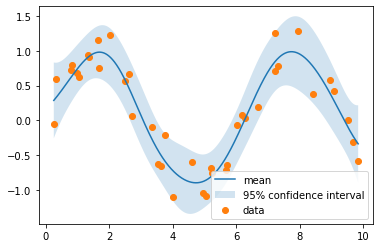

In [175]:
# X = np.arange(0, 20, 0.5).reshape(-1, 1)
X = np.random.uniform(0, 10, (40, 1))
Y = np.sin(X) + 0.2 * np.random.normal(0, 1, size = (len(X), 1))
m = GPReg(X, Y, gpflow.kernels.RBF(1), 0.2)
m.plot()

In [176]:
gpflow.kernels.RBF(1)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,1


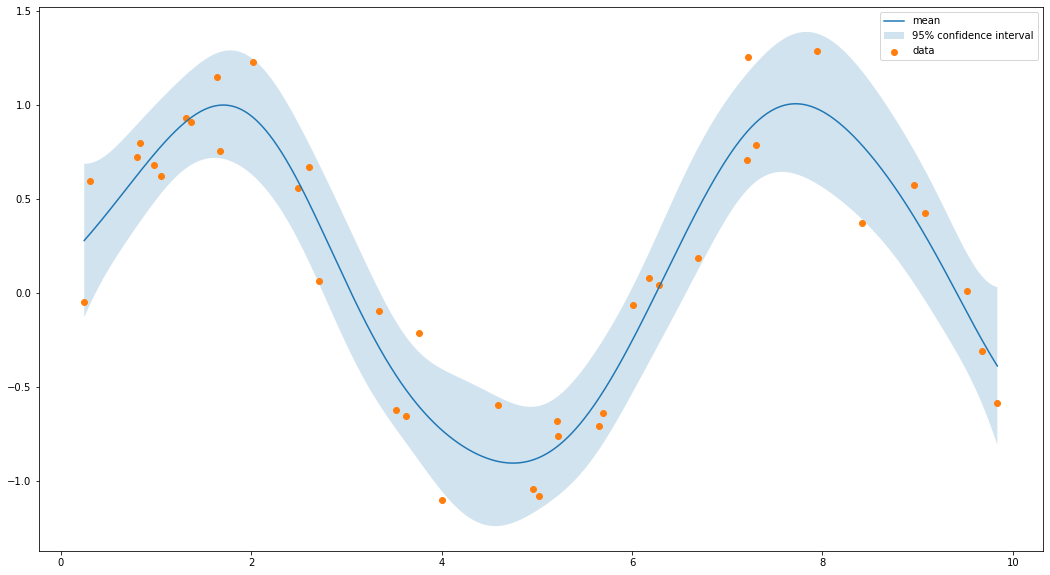

In [177]:
m.kernel.lengthscales.assign(1.0)
m.kernel.variance.assign(1.0)
m.gaussian_noise = 0.1
m.plot(figsize=(18, 10))

### Variational sparse GP

In [178]:
def get_cov(mat):
    """
    Takes a lower triangular matrix and returns a positive semi-definite matrix.
    
    Args:
        mat: a lower triangular matrix (tf 2D Tensor)
        
    Returns:
        positive semi-definite matrix, i.e. a valid covariance matrix.
    """
    return mat @ tf.transpose(mat)

In [187]:
class SparseGPReg(GPBase):
    """
    Variationally Sparse GP
    
    Args:
        X, Y: the data we are inferring from, arrays of shape (n, d) and (n, 1) respectively.
        Z: the inducing points (an m x d array) or the number of inducing points (int)
    """
    def __init__(self, X, Y, Z, kernel, gaussian_noise = 0.0):
        super().__init__(X, Y, kernel, gaussian_noise)
        if type(Z) == int:
            self.Z = self.place_inducing(Z)
        else:
            self.Z = tf.Variable(Z, dtype = default_float())
        
        self.num_inducing = self.Z.shape[0]
        # We want to randomly initialise mu and scale for q(u)
        # scale is a lower triangular matrix ensures the cov is positive semi-definite;
        # we then get the full cov by scale @ scale.T
        self.mu = np.random.normal(0, 0.2, size = (self.num_inducing, 1))
        self.scale = np.random.normal(0, 0.08, size = (self.num_inducing, self.num_inducing))
        self.scale = np.tril(self.scale)
        
        self.mu = tf.Variable(self.mu, dtype = default_float())
        self.scale = tf.Variable(self.scale, dtype = default_float())
        self.likelihood_var = 0.01
            
    def fit(self, batch_size, epochs, lr, fit_variational = True, fit_Z = False, fit_params = False):
        """
        Optimizes the variational mean and scale parameters, and the inducing points (optionally).
        
        Uses Adam optimisation to maximise the ELBO (minimise the negative ELBO).
        
        Args:
            batch_size: the number of datapoints to use at each step.
            epochs: the number of times the whole dataset is iterated over.
            lr: the learning rate of the optimiser.
            fit_z: whether to train the positions of the inducing points (default: False).

        Returns:
            None
        """
        assert any([fit_variational, fit_Z, fit_params]), "At least one parameter must be trained."
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
        ratio = self.X.shape[0]/batch_size
        self.gaussian_noise.assign(0.01)
        
        for epoch in range(epochs):
            batches = self._batchdata(batch_size)
            for batch_X, batch_Y in batches:
                with tf.GradientTape() as tape:
                    # Could we sample the hyperparameters at this point?
                    # Since we are iterating over the data multiple times, 
                    # just use a different hp combination for each batch sampled from a MVN?
                    # Seems like it would be faster but not very mathematically sound?
                    elbo_loss = 0

                    # Approximate E_(q_f)[log(Y|f)]
                    q_f_mu, q_f_cov = self.predict(batch_X, full_covariance = True) # Get mu and cov from prediction
                    q_f = tfd.MultivariateNormalFullCovariance(q_f_mu, q_f_cov) # Define q(f)
                    f = q_f.sample(1000) # Sample f from q(f)
                    p_y_f = tfd.Normal(f, self.likelihood_var) # STUCK HERE: Not sure what value to use for variance.
                    E_log_y_f = tf.math.reduce_mean(p_y_f.log_prob(batch_Y))
                    elbo_loss -= ratio * E_log_y_f
                    
                    # Get KL[q(u)||p(u)]
                    q_u = tfd.MultivariateNormalFullCovariance(self.mu, get_cov(self.scale))

                    p_u_mu = tf.zeros([1, self.num_inducing], dtype = default_float())
                    p_u_cov = self.kernel.K(self.Z, self.Z)
                    if len(p_u_cov.shape) > 2:
                        p_u_cov = tf.reduce_mean(p_u_cov, 0)
                    p_u = tfd.MultivariateNormalFullCovariance(p_u_mu, p_u_cov)

                    kl_q_u_p_u = tfd.kl_divergence(q_u, p_u)
                    elbo_loss += tf.math.reduce_mean(kl_q_u_p_u)
                
                # Now choose which parameters to train:
                to_update = []
                if fit_variational:
                    to_update.append(self.mu)
                    to_update.append(self.scale)
                if fit_Z:
                    to_update.append(self.Z)
                if fit_params:
                    for param in self.kernel.trainable_parameters:
                        to_update.append(param.unconstrained_variable)
                    #if epoch > .8 * epochs:
                    #    to_update.append(self.gaussian_noise)
                
                gradients = tape.gradient(elbo_loss, to_update)
                optimizer.apply_gradients(zip(gradients, to_update))
                
            if epoch % 10 == 0:
                print(f'{epoch}/{epochs}: elbo loss = {elbo_loss}')
    
    def predict(self, X_star, full_covariance = False, seperate = False):
        """
        The predicted mean and variance of each point in X_star.
        
        Args:
            X_star: the points to make a prediction at.
            full_covariance: whether to return a single variance value for each X_star or a full covariance 
            matrix on X_star.
        
        Returns:
            tuple (mu, var) where mu and var are arrays representing the predicted mean and variance respectively
            at each X_star. If full_covariance then var is a covariance matrix on X_star.
        """
        num_points = X_star.shape[0]
        
        Kxsz = self.kernel.K(X_star, self.Z)
        Kzz = self.kernel.K(self.Z, self.Z)
        InvKzz = tf.linalg.inv(Kzz + self.gaussian_noise * tf.eye(self.num_inducing, dtype = default_float()))
        Kxsxs = self.kernel.K(X_star, X_star)
        Kzxs = self.kernel.K(self.Z, X_star)
        
        mu = Kxsz @ InvKzz @ self.mu
        sig = Kxsxs - Kxsz @ InvKzz @ Kzxs + Kxsz @ InvKzz @ get_cov(self.scale) @ InvKzz @ Kzxs
        if not seperate and len(mu.shape) == 3:
            mu = tf.math.reduce_mean(mu, 0)
            sig = tf.math.reduce_mean(sig, 0)

        if full_covariance:
            return mu, sig
        else:
            var = tf.linalg.diag_part(sig)
            var = tf.reshape(var, (-1, num_points, 1))
            return mu, var
    
    def _batchdata(self, batch_size):
        """
        Batches the data into an iterator, randomly shuffling the order."""
        num_batches = self.X.shape[0]//batch_size
        
        indices = np.arange(0, self.Y.shape[0])
        np.random.shuffle(indices)
        indices = tf.convert_to_tensor(indices, tf.dtypes.int64)
        X = tf.gather(self.X, indices)
        Y = tf.gather(self.Y, indices)
        
        batches = []
        for i in range(num_batches):
            start, end = i*batch_size-1, (i+1)*batch_size-1
            batches.append((X[start:end], Y[start:end]))
        return iter(batches)
    
    def log_likelihood(self, theta):
        pass
    
    def plot(self, figsize = None):
        Z_points = np.array(self.Z).reshape(-1)
        y = np.zeros(self.Z.shape[0])
        plt.figure(figsize = figsize)
        plt.scatter(Z_points, y, c = 'black', marker = '+', label = 'inducing Point Locations')
        super().plot()
        
    def place_inducing(self, Z): 
        """
        Places Z inducing points around the d-dimensional space containing X using K-means clustering.
        Args:
            Z: the number of inducing points we want to initialise.
        """
        N, D = self.X.shape
        datapoints = np.array(self.X)
        kmeans = KMeans(n_clusters=Z).fit(datapoints)
        Z = kmeans.cluster_centers_
        Z = tf.Variable(Z, dtype = default_float())
        return Z

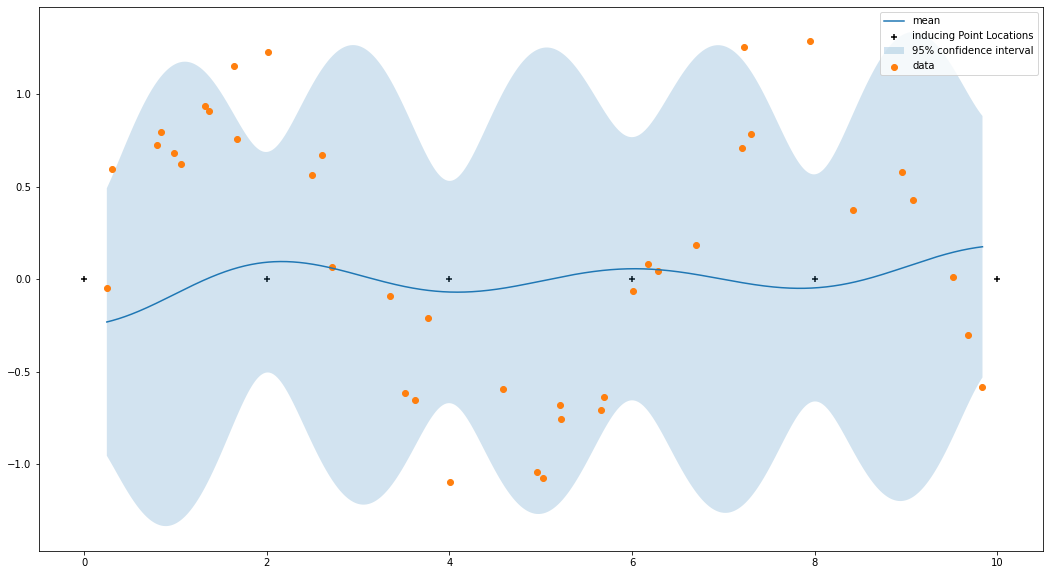

In [188]:
Z = np.arange(0, 12, 2).reshape(-1, 1)
sgpr = SparseGPReg(X, Y, Z, gpflow.kernels.RBF(1), 0.1)
sgpr.plot(figsize=(18, 10))

In [189]:
sgpr = SparseGPReg(X, Y, Z, gpflow.kernels.Matern52(1), 0.01)
sgpr.kernel.lengthscales.assign(1.0)
sgpr.kernel.variance.assign(0.5)
sgpr.fit(batch_size = 5, epochs = 300, lr = 0.02, fit_Z=False, fit_params=True)
sgpr.plot(figsize=(18, 10))

0/300: elbo loss = 17296.559498197144
10/300: elbo loss = 3036.7305565862575
20/300: elbo loss = 2262.3236196757075
30/300: elbo loss = 1228.9740222428406
40/300: elbo loss = 3430.567454746588
50/300: elbo loss = 886.309266721057
60/300: elbo loss = 2621.9269531896443
70/300: elbo loss = 3839.1672609823217
80/300: elbo loss = 1409.7716872062717
90/300: elbo loss = 2918.124494516028
100/300: elbo loss = 1169.2134484378955
110/300: elbo loss = 2267.2239465766197
120/300: elbo loss = 1808.3014017729888
130/300: elbo loss = 1239.971939731129
140/300: elbo loss = 495.8069160469365
150/300: elbo loss = 1266.1196311543604
160/300: elbo loss = 1275.6714038612313
170/300: elbo loss = 1351.4048906856665
180/300: elbo loss = 3998.657543858376
190/300: elbo loss = 2080.2244714588587
200/300: elbo loss = 1574.2640917548758
210/300: elbo loss = 1740.8264251978953
220/300: elbo loss = 2409.6089093045193
230/300: elbo loss = 2037.7684812773223
240/300: elbo loss = 1343.154797418449


InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [156]:
sgpr.kernel

name,class,transform,prior,trainable,shape,dtype,value
Matern52.variance,Parameter,Softplus,,True,(),float64,0.0197511
Matern52.lengthscales,Parameter,Softplus,,True,(),float64,0.986539


### Variational sparse GP with hyperparameter marginalisation

In [121]:
class VariKernel:
    def __init__(self, gpflow_k, param_names, num_samples = 1):
        self.gpflow_k = gpflow_k
        self.num_samples = num_samples
        self.kernels = [gpflow_k.copy() for i in range(self.num_samples)]
        self.param_names = param_names
    
    def K(self, X1, X2, param_samples = None):
        """
        Returns the covariance of K given each set of hyperparameters.
        
        Args:
            X1, X2: the two tensors between which the covariance is found.
            param_samples: a 2D tensor of shape(n_samples, n_parameters).
            The order of the hyperparameters should match the order of the original param_list
        
        Returns:
            an (N x L1 x L2) tensor where N is the number of hyperparameter samples and Li is the length of Xi.
            The [i,:,:] 2D tensor is K(X1, X2|theta i); the covariance of X1 and X2 for the ith hyperparameter configuration.
        """
        
        original_vals = self.get_param_dict()
        if param_samples is None:
            param_samples = self._sample_params(self.num_samples)
        elif type(param_samples) == int:
            param_samples = self._sample_params(param_samples)
        
        Kxx = [k.K(X1, X2) for k in self.kernels]
        return tf.stack(Kxx)

    def _sample_params(self, num):
        """TO DO"""
        loc = self.get_param_tensor()
        scale = tf.ones_like(loc, dtype = default_float()) * 0.5
        # hp_distribution = tfd.MultivariateNormalDiag(loc, scale)
        hp_distribution = tfd.Exponential(1/loc)
        samples = hp_distribution.sample(num)
        assert (samples > 0).numpy().all(), "Hyperparameters must be greater than 0"
        return samples
        
    def get_params(self):
        params = [{param: float(getattr(kern, param).numpy()) for param in self.param_names} for kern in self.kernels]
        return params
    
    def get_params_tensor(self):
        params = self.get_param_dicts()
        params_list = [list(kernel_params.values()) for kernel_params in params]
        np_params = np.array(params_list)
        return tf.Variable(np_params, dtype = default_float())
    
    def set_params(self, param_dicts):
        for i, kernel in enumerate(self.kernels):
            for param_name, param_value in param_dicts[i].items():
                param = getattr(kernel, param_name)
                param.assign(param_value)
    
    def set_params_tensor(self, param_tensor):
        params = []
        for i in range(self.num_samples):
            p_dict = {p_name: p_value for p_name, p_value in zip(self.param_names, param_tensor[i, :])}
            params.append(p_dict)
        self.set_params(params)

In [129]:
gpflow_kernel = gpflow.kernels.Matern52(2)
param_list = ['lengthscales', 'variance']

varikern = VariKernel(gpflow_kernel, param_list, 20)
varikern.get_param_dict()

new_ps = {'lengthscales': 1.0, 'variance': 1.0}
varikern.set_param_dict(new_ps)
varikern.get_param_tensor()

<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([1., 1.])>

In [132]:
sgpr = SparseGPReg(X, Y, 3, varikern, 0.005)
sgpr.kernel.gpflow_k.lengthscales.assign(1.0)
sgpr.kernel.gpflow_k.variance.assign(1.0)

X_star = tf.Variable([0.4, 0.9, 5], dtype = default_float())
X_star = tf.reshape(X_star, (-1, 1))

sgpr.predict(X_star)
# sgpr.fit(batch_size = 5, epochs = 100, lr = 0.05, fit_Z=True)

(<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
 array([[0.36247361],
        [0.45337847],
        [0.67507664]])>,
 <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
 array([[[ 1.59157548],
         [ 1.59157548],
         [-7.1836775 ]]])>)